<a href="https://colab.research.google.com/github/chiraagsharma24/CO2-Emissions-Prediction-model/blob/main/The_CO2_Emissions_Prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import io

print("Please upload your VehicularData.csv file:")
uploaded = files.upload()

# Check if the file was uploaded
if 'VehicularData.csv' in uploaded:
    print("\n'VehicularData.csv' uploaded successfully!")
    # Store the file name for later use
    file_name = 'VehicularData.csv'
else:
    print("\nError: 'VehicularData.csv' was not found in the uploaded files. Please make sure the file is named correctly and try again.")
    # Try to find any CSV file if the name is different
    csv_files = [k for k in uploaded.keys() if k.endswith('.csv')]
    if len(csv_files) == 1:
        print(f"Found '{csv_files[0]}' instead. We will use this file.")
        file_name = csv_files[0]
    elif len(csv_files) > 1:
        print(f"Multiple CSV files found: {csv_files}. Please upload only 'VehicularData.csv'.")
    else:
        print("No CSV file was uploaded.")

Please upload your VehicularData.csv file:


Saving VehicularData.csv to VehicularData.csv

'VehicularData.csv' uploaded successfully!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.models import load_model

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load the dataset
file_path = 'VehicularData.csv'
try:
    df = pd.read_csv(file_path)

    # Display basic information
    print("Data loaded successfully. Here's a summary of the data:")
    print(df.info())

    # Display the first 5 rows
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    # Display all column names
    print("\nColumn names:")
    print(df.columns.tolist())

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while loading the data: {e}")

Data loaded successfully. Here's a summary of the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91794 entries, 0 to 91793
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Car_Id                     91794 non-null  int64  
 1   Person_Id                  91794 non-null  int64  
 2   Trip                       91794 non-null  int64  
 3   GPS_Time                   91794 non-null  object 
 4   Device_Time                91794 non-null  object 
 5   GPS_Long                   91794 non-null  float64
 6   GPS_Lat                    91794 non-null  float64
 7   GPS_Speed_Ms               91794 non-null  float64
 8   GPS_HDOP                   91794 non-null  int64  
 9   GPS_Bearing                91794 non-null  float64
 10  Gx                         91794 non-null  float64
 11  Gy                         91794 non-null  float64
 12  Gz                         91794 non-null  flo

/tmp/ipython-input-3181545124.py:20: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [16]:
# Based on the paper's focus on OBD-II sensor data for CO2 prediction,
# we select the most relevant real-time vehicle operation features.

# List of features (X)
feature_columns = [
    'OBD_Speed_Km',
    'OBD_Engine_RPM',
    'OBD_Engine_Load',
    'OBD_Intake_Air_Temp_C',
    'OBD_Fuel_Flow_CCmin',
    'OBD_Air_Pedal',
    'OBD_Ambient_Air_Temp_C',
    'OBD_Engine_Coolant_Temp_C'
]

# The target variable (y)
target_column = 'OBD_CO2_gkm_Instant'

# Create a new DataFrame with only the selected features and target
selected_columns = feature_columns + [target_column]
df_selected = df[selected_columns].copy()

# Check for any non-numeric types in our selection that might need cleaning
# (e.g., the 'Device_Cost_Km_Inst' was object, but we are not using it)
print("Data types of selected columns:")
print(df_selected.info())

# Check for any missing values in this new DataFrame
print("\nMissing values in selected columns:")
print(df_selected.isnull().sum())

# Display the first 5 rows of the new DataFrame
print("\nFirst 5 rows of selected data:")
print(df_selected.head())

Data types of selected columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91794 entries, 0 to 91793
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OBD_Speed_Km               91794 non-null  int64  
 1   OBD_Engine_RPM             91794 non-null  float64
 2   OBD_Engine_Load            91794 non-null  float64
 3   OBD_Intake_Air_Temp_C      91794 non-null  int64  
 4   OBD_Fuel_Flow_CCmin        91794 non-null  float64
 5   OBD_Air_Pedal              91794 non-null  float64
 6   OBD_Ambient_Air_Temp_C     91794 non-null  int64  
 7   OBD_Engine_Coolant_Temp_C  91794 non-null  int64  
 8   OBD_CO2_gkm_Instant        91794 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 6.3 MB
None

Missing values in selected columns:
OBD_Speed_Km                 0
OBD_Engine_RPM               0
OBD_Engine_Load              0
OBD_Intake_Air_Temp_C        0
OBD_Fuel_Flow_CCmin         

Feature ranking by PCA loading vector length (desc):
OBD_Engine_Load 0.9077
OBD_Speed_Km 0.7315
OBD_Engine_RPM 0.4633
OBD_Air_Pedal 0.4
OBD_Ambient_Air_Temp_C 0.3919
OBD_Intake_Air_Temp_C 0.2327
OBD_Fuel_Flow_CCmin 0.2275
OBD_Engine_Coolant_Temp_C 0.0825


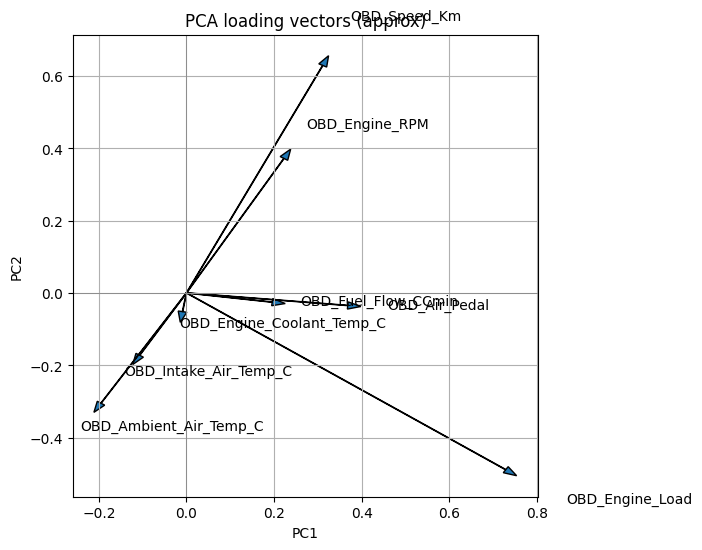

In [18]:
# Cell 6 - PCA to show loading scores (for ranking features)
X_for_pca = df[feature_columns].dropna()
scaler_pca = MinMaxScaler()
X_scaled = scaler_pca.fit_transform(X_for_pca)

pca = PCA(n_components=2)
pca.fit(X_scaled)
loadings = pca.components_.T  # shape (n_features, n_components)
loading_scores = np.linalg.norm(loadings, axis=1)
feature_ranking = sorted(zip(feature_columns, loading_scores), key=lambda x: x[1], reverse=True)
print("Feature ranking by PCA loading vector length (desc):")
for feat, score in feature_ranking:
    print(feat, round(float(score), 4))

# Optional biplot-like visualization
plt.figure(figsize=(6,6))
for i, feat in enumerate(feature_columns):
    plt.arrow(0,0, loadings[i,0], loadings[i,1], head_width=0.02, length_includes_head=True)
    plt.text(loadings[i,0]*1.15, loadings[i,1]*1.15, feat)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA loading vectors (approx)")
plt.grid()
plt.axhline(0, color='grey', linewidth=0.5)
plt.axvline(0, color='grey', linewidth=0.5)
plt.show()


In [ ]:
# Separate features (X) and target (y)
X = df_selected[feature_columns].values
y = df_selected[target_column].values.reshape(-1, 1) # Reshape for scaler

# Perform an 80/20 train-test split (sequential, no shuffling)
split_index = int(len(X) * 0.8)

X_train_raw = X[:split_index]
y_train_raw = y[:split_index]
X_test_raw = X[split_index:]
y_test_raw = y[split_index:]

# Initialize scalers
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scalers ONLY on the training data
X_train_scaled = x_scaler.fit_transform(X_train_raw)
y_train_scaled = y_scaler.fit_transform(y_train_raw)

# Transform the test data using the fitted scalers
X_test_scaled = x_scaler.transform(X_test_raw)
y_test_scaled = y_scaler.transform(y_test_raw)

print(f"Total samples: {len(X)}")
print(f"Training samples (X, y): {X_train_scaled.shape}, {y_train_scaled.shape}")
print(f"Testing samples (X, y): {X_test_scaled.shape}, {y_test_scaled.shape}")
print("\nData has been scaled and split.")

Total samples: 91794
Training samples (X, y): (73435, 8), (73435, 1)
Testing samples (X, y): (18359, 8), (18359, 1)

Data has been scaled and split.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import load_model
import joblib # Using joblib to save the scaler

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# --- 1. Load Data ---
file_path = 'VehicularData.csv'
try:
    # Use low_memory=False to suppress the DtypeWarning
    df = pd.read_csv(file_path, low_memory=False)
    print("Loaded VehicularData.csv")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please re-upload the file.")
    # We can't proceed if the file isn't there.
    # This will stop the cell execution if the file is missing.
    raise

# --- 2. Feature Selection ---
feature_columns = [
    'OBD_Speed_Km', 'OBD_Engine_RPM', 'OBD_Engine_Load',
    'OBD_Intake_Air_Temp_C', 'OBD_Fuel_Flow_CCmin', 'OBD_Air_Pedal',
    'OBD_Ambient_Air_Temp_C', 'OBD_Engine_Coolant_Temp_C'
]
target_column = 'OBD_CO2_gkm_Instant'
df_selected = df[feature_columns + [target_column]].copy()

# --- 3. Scale and Split ---
X = df_selected[feature_columns].values
y = df_selected[target_column].values.reshape(-1, 1)

split_index = int(len(X) * 0.8)
X_train_raw, y_train_raw = X[:split_index], y[:split_index]
X_test_raw, y_test_raw = X[split_index:], y[split_index:]

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = x_scaler.fit_transform(X_train_raw)
y_train_scaled = y_scaler.fit_transform(y_train_raw)

# --- THIS IS THE CORRECTED LINE ---
X_test_scaled = x_scaler.transform(X_test_raw)
y_test_scaled = y_scaler.transform(y_test_raw) # Was incorrectly X_test_raw

# Save the scaler object for later
joblib.dump(y_scaler, 'y_scaler.joblib')
joblib.dump(x_scaler, 'x_scaler.joblib')
print("Scalers have been created and saved.")

# --- 4. Create Sequences ---
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        v = X[i:(i + time_step), :]
        Xs.append(v)
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

time_step = 10
X_train, y_train = create_dataset(X_train_scaled, y_train_scaled, time_step)
X_test, y_test = create_dataset(X_test_scaled, y_test_scaled, time_step)

print(f"Sequence train X shape: {X_train.shape}")
print(f"Sequence train y shape: {y_train.shape}")
print(f"Sequence test X shape: {X_test.shape}")
print(f"Sequence test y shape: {y_test.shape}")

# Save the test data for evaluation later
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
np.save('y_test_raw.npy', y_test_raw) # Save raw test target for comparison

# --- 5. Define and Train LSTM Model ---
input_shape = (X_train.shape[1], X_train.shape[2])

inputs_lstm = Input(shape=input_shape)
x_lstm = LSTM(100, return_sequences=False)(inputs_lstm)
outputs_lstm = Dense(1)(x_lstm)
model_lstm = Model(inputs_lstm, outputs_lstm)

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

print("\nLSTM Model Architecture:")
model_lstm.summary()

print("\nTraining LSTM model...")
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    verbose=1
)

model_lstm.save('lstm_model.h5')
print("\nTrained LSTM model saved as 'lstm_model.h5'")

Loaded VehicularData.csv
Scalers have been created and saved.
Sequence train X shape: (73425, 10, 8)
Sequence train y shape: (73425, 1)
Sequence test X shape: (18349, 10, 8)
Sequence test y shape: (18349, 1)

LSTM Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,701 (170.71 KB)

 Trainable params: 43,701 (170.71 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0072 - val_loss: 0.0028
Epoch 2/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 3/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 4/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 5/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 6/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 7/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 8/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 9/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 10/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 11/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0025 - v


Trained LSTM model saved as 'lstm_model.h5'


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import load_model
import joblib

# Set random seed for reproducibility
tf.random.set_seed(42)
# --- THIS IS THE CORRECTED LINE ---
np.random.seed(42)

# --- 1. Load Data ---
file_path = 'VehicularData.csv'
try:
    df = pd.read_csv(file_path, low_memory=False)
    print("Loaded VehicularData.csv")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please re-upload the file.")
    raise

# --- 2. Feature Selection ---
feature_columns = [
    'OBD_Speed_Km', 'OBD_Engine_RPM', 'OBD_Engine_Load',
    'OBD_Intake_Air_Temp_C', 'OBD_Fuel_Flow_CCmin', 'OBD_Air_Pedal',
    'OBD_Ambient_Air_Temp_C', 'OBD_Engine_Coolant_Temp_C'
]
target_column = 'OBD_CO2_gkm_Instant'
df_selected = df[feature_columns + [target_column]].copy()

# --- 3. Scale and Split ---
X = df_selected[feature_columns].values
y = df_selected[target_column].values.reshape(-1, 1)

split_index = int(len(X) * 0.8)
X_train_raw, y_train_raw = X[:split_index], y[:split_index]
X_test_raw, y_test_raw = X[split_index:], y[split_index:]

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = x_scaler.fit_transform(X_train_raw)
y_train_scaled = y_scaler.fit_transform(y_train_raw)
X_test_scaled = x_scaler.transform(X_test_raw)
y_test_scaled = y_scaler.transform(y_test_raw)
print("Data scaled and split.")

# --- 4. Create Sequences ---
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        v = X[i:(i + time_step), :]
        Xs.append(v)
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

time_step = 10
X_train, y_train = create_dataset(X_train_scaled, y_train_scaled, time_step)
# We don't need X_test/y_test in this cell, but we create X_train/y_train
print(f"Sequence train X shape: {X_train.shape}")

# --- 5. Define and Train GRU Model ---
input_shape = (X_train.shape[1], X_train.shape[2])

inputs_gru = Input(shape=input_shape)
# GRU layer with 100 units, similar to the LSTM
x_gru = GRU(100, return_sequences=False)(inputs_gru)
outputs_gru = Dense(1)(x_gru)
model_gru = Model(inputs_gru, outputs_gru)

model_gru.compile(optimizer='adam', loss='mean_squared_error')

print("\nGRU Model Architecture:")
model_gru.summary()

print("\nTraining GRU model...")
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    verbose=1
)

model_gru.save('gru_model.h5')
print("\nTrained GRU model saved as 'gru_model.h5'")

Loaded VehicularData.csv
Data scaled and split.
Sequence train X shape: (73425, 10, 8)

GRU Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100)            │        33,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,101 (129.30 KB)

 Trainable params: 33,101 (129.30 KB)

 Non-trainable params: 0 (0.00 B)


Training GRU model...
Epoch 1/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - loss: 0.0064 - val_loss: 0.0030
Epoch 2/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0044 - val_loss: 0.0023
Epoch 3/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 4/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 5/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 6/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0030 - val_loss: 0.0018
Epoch 7/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 8/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 9/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 10/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 11/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0025 - va


Trained GRU model saved as 'gru_model.h5'


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import load_model
import joblib

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# --- 1. Load Data ---
file_path = 'VehicularData.csv'
try:
    df = pd.read_csv(file_path, low_memory=False)
    print("Loaded VehicularData.csv")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please re-upload the file.")
    raise

# --- 2. Feature Selection ---
feature_columns = [
    'OBD_Speed_Km', 'OBD_Engine_RPM', 'OBD_Engine_Load',
    'OBD_Intake_Air_Temp_C', 'OBD_Fuel_Flow_CCmin', 'OBD_Air_Pedal',
    'OBD_Ambient_Air_Temp_C', 'OBD_Engine_Coolant_Temp_C'
]
target_column = 'OBD_CO2_gkm_Instant'
df_selected = df[feature_columns + [target_column]].copy()

# --- 3. Scale and Split ---
X = df_selected[feature_columns].values
y = df_selected[target_column].values.reshape(-1, 1)

split_index = int(len(X) * 0.8)
X_train_raw, y_train_raw = X[:split_index], y[:split_index]
X_test_raw, y_test_raw = X[split_index:], y[split_index:]

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = x_scaler.fit_transform(X_train_raw)
y_train_scaled = y_scaler.fit_transform(y_train_raw)
X_test_scaled = x_scaler.transform(X_test_raw)
y_test_scaled = y_scaler.transform(y_test_raw)
print("Data scaled and split.")

# --- 4. Create Sequences ---
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        v = X[i:(i + time_step), :]
        Xs.append(v)
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

time_step = 10
X_train, y_train = create_dataset(X_train_scaled, y_train_scaled, time_step)
print(f"Sequence train X shape: {X_train.shape}")

# --- 5. Define and Train Bi-LSTM Model ---
input_shape = (X_train.shape[1], X_train.shape[2])

inputs_bilstm = Input(shape=input_shape)
# Wrap the LSTM layer with Bidirectional
# This will process the sequence forwards and backwards
x_bilstm = Bidirectional(LSTM(100, return_sequences=False))(inputs_bilstm)
outputs_bilstm = Dense(1)(x_bilstm)
model_bilstm = Model(inputs_bilstm, outputs_bilstm)

model_bilstm.compile(optimizer='adam', loss='mean_squared_error')

print("\nBidirectional LSTM Model Architecture:")
model_bilstm.summary()

print("\nTraining Bi-LSTM model...")
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    verbose=1
)

model_bilstm.save('bilstm_model.h5')
print("\nTrained Bi-LSTM model saved as 'bilstm_model.h5'")

Loaded VehicularData.csv
Data scaled and split.
Sequence train X shape: (73425, 10, 8)

Bidirectional LSTM Model Architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200)            │        87,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,401 (341.41 KB)

 Trainable params: 87,401 (341.41 KB)

 Non-trainable params: 0 (0.00 B)


Training Bi-LSTM model...
Epoch 1/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - loss: 0.0068 - val_loss: 0.0025
Epoch 2/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.0039 - val_loss: 0.0023
Epoch 3/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 4/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 5/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 6/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 7/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 8/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 9/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 10/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 11/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0025 


Trained Bi-LSTM model saved as 'bilstm_model.h5'


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import load_model
import joblib

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# --- 1. Load Data ---
file_path = 'VehicularData.csv'
try:
    df = pd.read_csv(file_path, low_memory=False)
    print("Loaded VehicularData.csv")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please re-upload the file.")
    raise

# --- 2. Feature Selection ---
feature_columns = [
    'OBD_Speed_Km', 'OBD_Engine_RPM', 'OBD_Engine_Load',
    'OBD_Intake_Air_Temp_C', 'OBD_Fuel_Flow_CCmin', 'OBD_Air_Pedal',
    'OBD_Ambient_Air_Temp_C', 'OBD_Engine_Coolant_Temp_C'
]
target_column = 'OBD_CO2_gkm_Instant'
df_selected = df[feature_columns + [target_column]].copy()

# --- 3. Scale and Split ---
X = df_selected[feature_columns].values
y = df_selected[target_column].values.reshape(-1, 1)

split_index = int(len(X) * 0.8)
X_train_raw, y_train_raw = X[:split_index], y[:split_index]
X_test_raw, y_test_raw = X[split_index:], y[:split_index:]

x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = x_scaler.fit_transform(X_train_raw)
y_train_scaled = y_scaler.fit_transform(y_train_raw)
X_test_scaled = x_scaler.transform(X_test_raw)
y_test_scaled = y_scaler.transform(y_test_raw)
print("Data scaled and split.")

# --- 4. Create Sequences ---
def create_dataset(X, y, time_step=1):
    Xs, ys = [], []
    for i in range(len(X) - time_step):
        v = X[i:(i + time_step), :]
        Xs.append(v)
        ys.append(y[i + time_step])
    return np.array(Xs), np.array(ys)

time_step = 10
X_train, y_train = create_dataset(X_train_scaled, y_train_scaled, time_step)
print(f"Sequence train X shape: {X_train.shape}")

# --- 5. Define and Train 1D CNN-LSTM Model ---
input_shape = (X_train.shape[1], X_train.shape[2])

inputs_hybrid = Input(shape=input_shape)
# 1. 1D CNN layer to find patterns in the 10 time steps
# 64 filters, kernel size of 2
x_hybrid = Conv1D(filters=64, kernel_size=2, activation='relu')(inputs_hybrid)
# 2. Max pooling to reduce dimensionality
x_hybrid = MaxPooling1D(pool_size=2)(x_hybrid)
# 3. LSTM layer to understand the sequence of features
x_hybrid = LSTM(100, return_sequences=False)(x_hybrid)
# 4. Output layer
outputs_hybrid = Dense(1)(x_hybrid)

model_hybrid = Model(inputs_hybrid, outputs_hybrid)

model_hybrid.compile(optimizer='adam', loss='mean_squared_error')

print("\n1D CNN-LSTM Hybrid Model Architecture:")
model_hybrid.summary()

print("\nTraining 1D CNN-LSTM model...")
history_hybrid = model_hybrid.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    verbose=1
)

model_hybrid.save('cnn_lstm_model.h5')
print("\nTrained 1D CNN-LSTM model saved as 'cnn_lstm_model.h5'")

Loaded VehicularData.csv
Data scaled and split.
Sequence train X shape: (73425, 10, 8)

1D CNN-LSTM Hybrid Model Architecture:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 10, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 9, 64)          │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,189 (262.46 KB)

 Trainable params: 67,189 (262.46 KB)

 Non-trainable params: 0 (0.00 B)


Training 1D CNN-LSTM model...
Epoch 1/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 2/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 3/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 4/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 5/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0042 - val_loss: 0.0032
Epoch 6/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 7/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 8/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 9/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 10/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 11/50
1836/1836 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.0039 - val_l


Trained 1D CNN-LSTM model saved as 'cnn_lstm_model.h5'


In [8]:
import pandas as pd
import numpy as np
import math
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os # To check if files exist

# --- Helper function to calculate all metrics ---
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return mae, mse, rmse

# --- List of model files to evaluate ---
model_files = {
    "LSTM": "lstm_model.h5",
    "GRU": "gru_model.h5",
    "Bi-LSTM": "bilstm_model.h5",
    "1D CNN-LSTM": "cnn_lstm_model.h5"
}

# --- Data and scaler files ---
TEST_DATA_X = 'X_test.npy'
TEST_DATA_Y = 'y_test.npy'
SCALER_Y = 'y_scaler.joblib'

# --- Store results ---
results = []

try:
    # --- 1. Load Test Data and Scaler ---
    X_test = np.load(TEST_DATA_X)
    y_test_scaled = np.load(TEST_DATA_Y)
    y_scaler = joblib.load(SCALER_Y)

    # Inverse transform the true y values to get their actual CO2 values
    y_test_actual = y_scaler.inverse_transform(y_test_scaled)

    print(f"Loaded test data: X_test shape {X_test.shape}, y_test shape {y_test_actual.shape}")
    print(f"Loaded y_scaler.")
    print("-" * 30)

    # --- 2. Loop, Predict, and Evaluate ---
    for model_name, file_name in model_files.items():
        if not os.path.exists(file_name):
            print(f"Warning: Model file '{file_name}' not found. Skipping {model_name}.")
            continue

        print(f"Evaluating model: {model_name} ({file_name})")

        # Load the trained model
        model = load_model(file_name)

        # Make predictions (scaled)
        y_pred_scaled = model.predict(X_test)

        # Inverse transform predictions to get actual CO2 values
        y_pred_actual = y_scaler.inverse_transform(y_pred_scaled)

        # Calculate metrics
        mae, mse, rmse = calculate_metrics(y_test_actual, y_pred_actual)

        # Print and store results
        print(f"  MAE:  {mae:.2f}")
        print(f"  MSE:  {mse:.2f}")
        print(f"  RMSE: {rmse:.2f}\n")

        results.append({
            "Model": model_name,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        })

    # --- 3. Display Final Comparison Table ---
    if results:
        results_df = pd.DataFrame(results).set_index("Model")
        print("\n" + "=" * 40)
        print("         FINAL MODEL COMPARISON")
        print("=" * 40)
        print(results_df.to_markdown(floatfmt=".2f"))
    else:
        print("\nNo models were found to evaluate. Please run the training cells.")

except FileNotFoundError as e:
    print(f"\nError: A necessary file was not found: {e.fileName}")
    print("Please make sure you have run all the previous training cells to generate the models and test data files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Loaded test data: X_test shape (18349, 10, 8), y_test shape (18349, 1)
Loaded y_scaler.
------------------------------
Evaluating model: LSTM (lstm_model.h5)
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


  MAE:  174.52
  MSE:  93459.76
  RMSE: 305.71

Evaluating model: GRU (gru_model.h5)
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


  MAE:  302.32
  MSE:  240023.58
  RMSE: 489.92

Evaluating model: Bi-LSTM (bilstm_model.h5)
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


  MAE:  181.43
  MSE:  100367.25
  RMSE: 316.81

Evaluating model: 1D CNN-LSTM (cnn_lstm_model.h5)
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
  MAE:  135.61
  MSE:  47938.74
  RMSE: 218.95


         FINAL MODEL COMPARISON
| Model       |    MAE |       MSE |   RMSE |
|:------------|-------:|----------:|-------:|
| LSTM        | 174.52 |  93459.76 | 305.71 |
| GRU         | 302.32 | 240023.58 | 489.92 |
| Bi-LSTM     | 181.43 | 100367.25 | 316.81 |
| 1D CNN-LSTM | 135.61 |  47938.74 | 218.95 |


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import math
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# --- Load Test Data and Scaler ---
X_test = np.load('X_test.npy')
y_test_scaled = np.load('y_test.npy')
y_scaler = joblib.load('y_scaler.joblib')

# Get the actual (un-scaled) true values
y_test_actual = y_scaler.inverse_transform(y_test_scaled)

# --- Load Models and Make Predictions ---
print("Loading models and making predictions...")

# Load models
model_lstm = load_model('lstm_model.h5')
model_gru = load_model('gru_model.h5')
model_bilstm = load_model('bilstm_model.h5')
model_hybrid = load_model('cnn_lstm_model.h5') # Your "proposed" model

# Make scaled predictions
y_pred_scaled_lstm = model_lstm.predict(X_test)
y_pred_scaled_gru = model_gru.predict(X_test)
y_pred_scaled_bilstm = model_bilstm.predict(X_test)
y_pred_scaled_hybrid = model_hybrid.predict(X_test)

# Inverse transform predictions to actual CO2 values
y_pred_actual_lstm = y_scaler.inverse_transform(y_pred_scaled_lstm)
y_pred_actual_gru = y_scaler.inverse_transform(y_pred_scaled_gru)
y_pred_actual_bilstm = y_scaler.inverse_transform(y_pred_scaled_bilstm)
y_pred_actual_hybrid = y_scaler.inverse_transform(y_pred_scaled_hybrid)

print("All predictions are ready.")

# Create a DataFrame for easy plotting
results_df = pd.DataFrame({
    'True Values': y_test_actual.flatten(),
    'LSTM': y_pred_actual_lstm.flatten(),
    'GRU': y_pred_actual_gru.flatten(),
    'Bi-LSTM': y_pred_actual_bilstm.flatten(),
    '1D CNN-LSTM': y_pred_actual_hybrid.flatten()
})

Loading models and making predictions...


574/574 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
All predictions are ready.


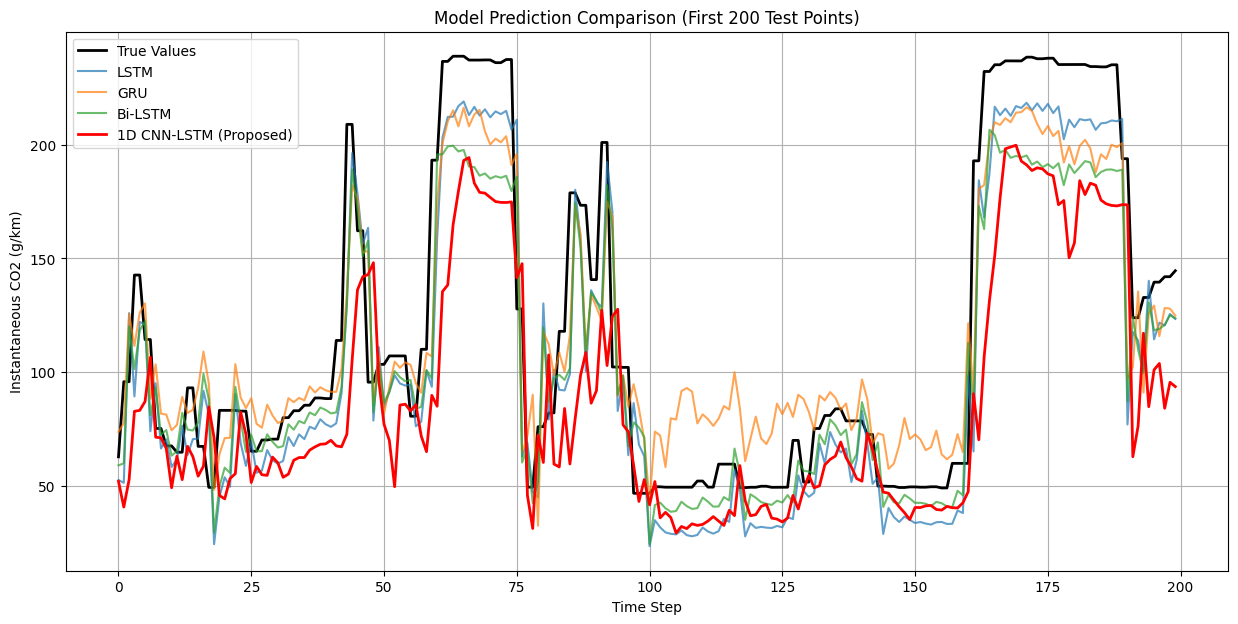

In [21]:
# We'll plot the first 200 data points from the test set
plot_points = 200

plt.figure(figsize=(15, 7))
plt.plot(results_df['True Values'].head(plot_points), label='True Values', color='black', linewidth=2)
plt.plot(results_df['LSTM'].head(plot_points), label='LSTM', linestyle='-', alpha=0.7)
plt.plot(results_df['GRU'].head(plot_points), label='GRU', linestyle='-', alpha=0.7)
plt.plot(results_df['Bi-LSTM'].head(plot_points), label='Bi-LSTM', linestyle='-', alpha=0.7)
plt.plot(results_df['1D CNN-LSTM'].head(plot_points), label='1D CNN-LSTM (Proposed)', color='red', linestyle='-', linewidth=2)

plt.title('Model Prediction Comparison (First 200 Test Points)')
plt.xlabel('Time Step')
plt.ylabel('Instantaneous CO2 (g/km)')
plt.legend()
plt.grid(True)
plt.show()

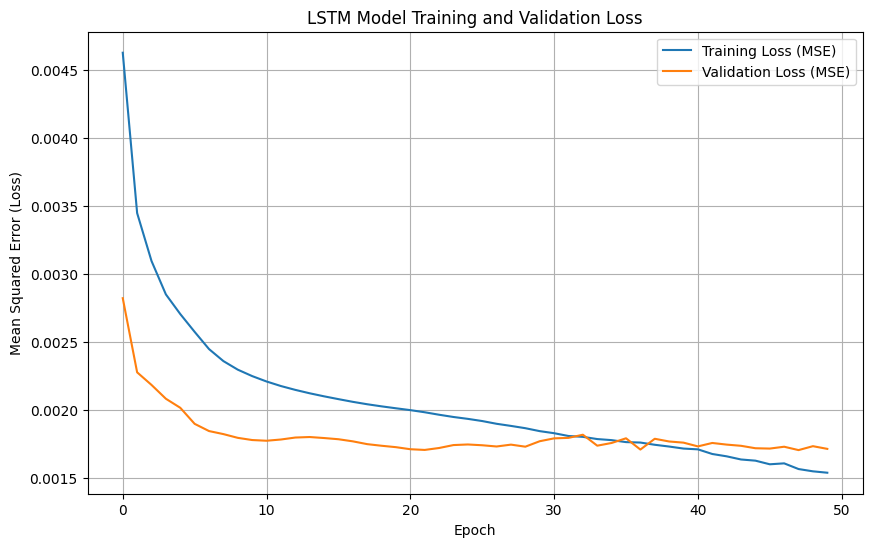

In [24]:
# This code assumes you have run the LSTM training cell
# and the 'history_lstm' object is in memory.

if 'history_lstm' in locals() or 'history_lstm' in globals():
    plt.figure(figsize=(10, 6))
    plt.plot(history_lstm.history['loss'], label='Training Loss (MSE)')
    plt.plot(history_lstm.history['val_loss'], label='Validation Loss (MSE)')
    plt.title('LSTM Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error (Loss)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Error: 'history_lstm' object not found.")
    print("Please re-run the LSTM model training cell first, then run this cell again.")

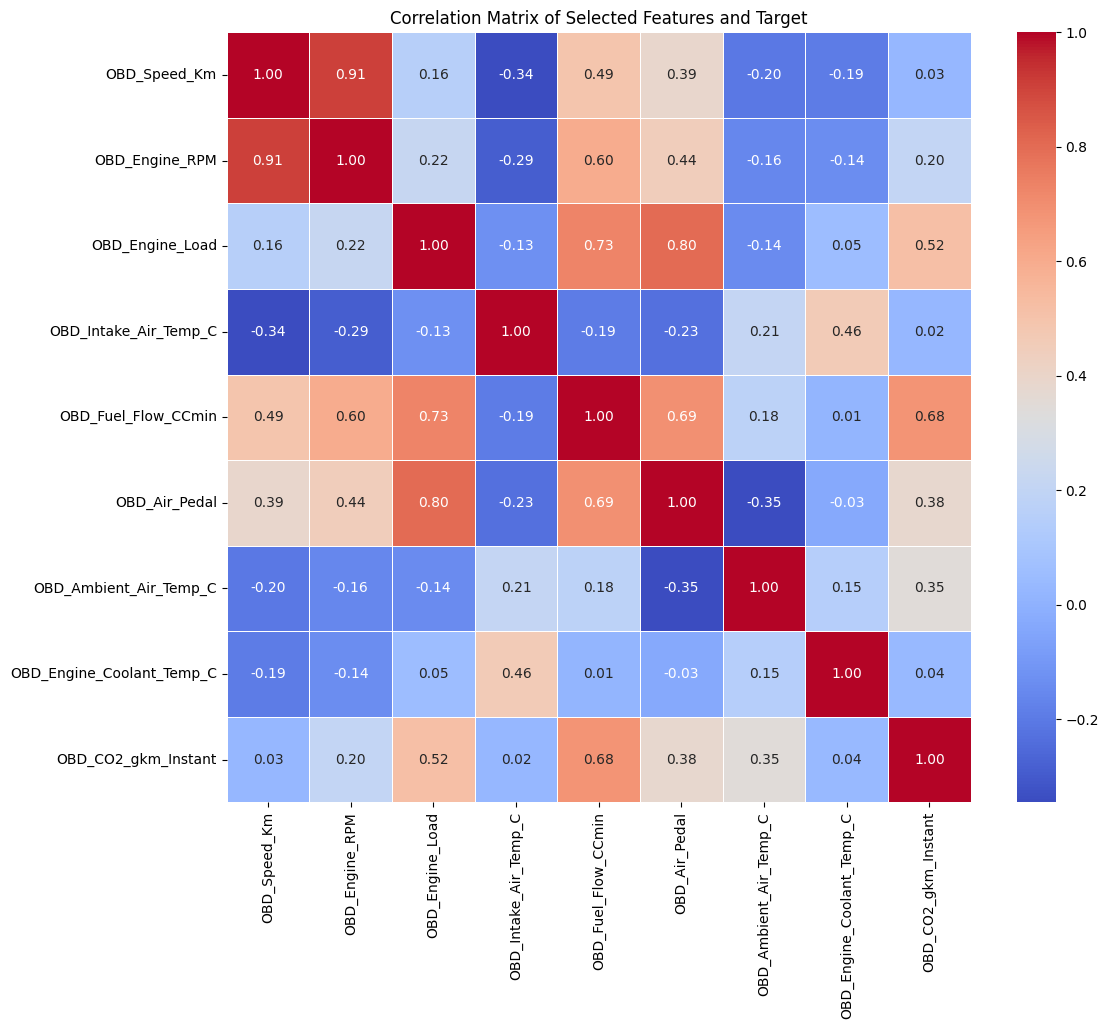

In [26]:
# We need to re-load the original dataframe to get the selected columns
df_original = pd.read_csv('VehicularData.csv', low_memory=False)

feature_columns = [
    'OBD_Speed_Km', 'OBD_Engine_RPM', 'OBD_Engine_Load',
    'OBD_Intake_Air_Temp_C', 'OBD_Fuel_Flow_CCmin', 'OBD_Air_Pedal',
    'OBD_Ambient_Air_Temp_C', 'OBD_Engine_Coolant_Temp_C'
]
target_column = 'OBD_CO2_gkm_Instant'

# Create the dataframe with just our features and target
df_for_corr = df_original[feature_columns + [target_column]].copy()

# Calculate the correlation matrix
corr_matrix = df_for_corr.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Selected Features and Target')
plt.show()